# Simple trajectories visualization for generic model

In [1]:
import sys
import pickle
import pandas as pd

import torch
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

#sys.path.append('../..')
#from src.losses import get_loss_mask
plt.rcParams.update({'font.size': 16})

In [2]:
def get_loss_mask(seq_list):
    """
    Get a mask to denote whether to account prediction during loss/metrics
    computation. It is supposed to calculate loss/metrics for a person at
    time t only if his data exists from time 0 to time t.

    Parameters
    ----------
    seq_list : PyTorch tensor
        input is seq_list[1:]. Size = (seq_len,N_pedestrians). Boolean mask
        that is =1 if pedestrian i is present at time-step t.

    Returns
    -------
    loss_mask : PyTorch tensor
        Shape: (seq_len,N_pedestrians)
        loss_mask[t,i] = 1 if pedestrian i if present from beginning till time t
    """
    loss_mask = seq_list.cumprod(dim=0)
    # we should not compute loss/metrics for step 0, as ground_truth and
    # predictions are always equal there
    loss_mask[0] = 0
    return loss_mask

In [73]:
PATH = "C:\\Users\\aless\\Desktop\\random"

## Choose experiment

In [74]:
# other parameters
obs_length = 5
seq_length = 35

# COORDINATE RIFERITE A TRAIETTORIE per settare immagine (DEPRECATED)
max_x = 44.281
max_y = 34.4
min_x = -1.665
min_y = -1.87

In [139]:
# main parameters
test_set = 'SCREEN-test'
phase = 'test'
checkpoint = '002'

path = f"{PATH}\\output_{phase}_epoch_{checkpoint}.cpkl"

In [140]:
with (open(path, "rb")) as openfile:
    trajectories_out = pickle.load(openfile)
print("Loaded. Number of test batches:", len(trajectories_out))

Loaded. Number of test batches: 185


## Choose batch

In [50]:
# NEW RESULTS
#batch_idx = 8
batch_idx = 280
inputs, all_output = trajectories_out[batch_idx]
batch_abs, batch_shifted, shift_value, seq_list = inputs

In [51]:
loss_mask = get_loss_mask(seq_list)
agent_full = torch.sum(loss_mask, dim=0) == seq_length - 1
print("Number of pedestrians:", batch_shifted.shape[1])
print("Number of full pedestrian:", sum(agent_full).item())
print("Full pedestrians indices:", np.where(agent_full.cpu().numpy())[0])

Number of pedestrians: 33
Number of full pedestrian: 33
Full pedestrians indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32]


# Automatic print


In [10]:
img = plt.imread("mappa.jpg")
dim = img.shape
dim_y = dim[0]
dim_x = dim[1]
ratio = dim_y/ dim_x
new_width = 45
trans_x = 0
trans_y = -1.2

In [129]:
def print_fig_traj(idx, pad):
    for id in idx:
        ped_idx = id

        ground_truth = batch_abs[:,ped_idx,:]
        if phase == 'train':
            predictions = all_output[:,ped_idx,:] + shift_value[:,ped_idx,:]
        else:
            predictions = all_output[:,:,ped_idx,:] + shift_value[:,ped_idx,:]
        ground_truth = ground_truth.cpu().numpy()
        predictions = predictions.cpu().numpy()
        
        fig, ax = plt.subplots(figsize=(10, 10))

        img = plt.imread("mappa.jpg")
        ax.imshow(img, extent=[trans_x, new_width + trans_x, trans_y, new_width*ratio + trans_y], alpha = 0.3)
        
        x_min = ground_truth[:obs_length, 0].min() - pad
        x_max = ground_truth[obs_length:, 0].max() + pad
        y_min = ground_truth[:obs_length, 1].min() - pad
        y_max = ground_truth[obs_length:, 1].max() + pad      
        
        x_min = 0
        x_max = 17
        y_min = 1
        y_max = 21
        
        ax.plot(ground_truth[:obs_length, 0], ground_truth[:obs_length, 1],
                '-o', color='black', label='Observation')
        ax.plot(ground_truth[obs_length:, 0], ground_truth[obs_length:, 1],
                '-o', color='blue', label='Prediction')
        ax.set(title='Ground truth')
        #ax.legend()

        plt.axis([x_min, x_max, y_min, y_max])
        
        plt.savefig(f"{PATH}\\{ped_idx}_gt.png", format="png")
        
        fig, ax = plt.subplots(figsize=(10, 10))

        img = plt.imread("mappa.jpg")
        ax.imshow(img, extent=[trans_x, new_width + trans_x, trans_y, new_width*ratio + trans_y], alpha = 0.3)

        if phase == 'train':
            ax.plot(ground_truth[:obs_length, 0], ground_truth[:obs_length, 1],
                '-o', color='black', label='Observation')
            ax.plot(predictions[obs_length:, 0], predictions[obs_length:, 1],
                '-o', label='Prediction')
            #ax.legend()
        else:
            for pred in predictions:
                ax.plot(ground_truth[:obs_length, 0], ground_truth[:obs_length, 1],
                    '-o', color='black', label='Observation')
                ax.plot(pred[obs_length:, 0], pred[obs_length:, 1],
                    '-o', label='Prediction')
        ax.set(title='Predictions')

        plt.axis([x_min, x_max, y_min, y_max])
        
        plt.savefig(f"{PATH}\\{ped_idx}_pred.png")
        

In [12]:
def print_pure_traj(idx, pad):
    for id in idx:
        ped_idx = id

        ground_truth = batch_abs[:,ped_idx,:]
        if phase == 'train':
            predictions = all_output[:,ped_idx,:] + shift_value[:,ped_idx,:]
        else:
            predictions = all_output[:,:,ped_idx,:] + shift_value[:,ped_idx,:]
        ground_truth = ground_truth.cpu().numpy()
        predictions = predictions.cpu().numpy()
        
        fig, ax = plt.subplots(figsize=(10, 10))
        
        x_min = ground_truth[:obs_length, 0].min() - pad
        x_max = ground_truth[obs_length:, 0].max() + pad
        y_min = ground_truth[:obs_length, 1].min() - pad
        y_max = ground_truth[obs_length:, 1].max() + pad      
        
        ax.plot(ground_truth[:obs_length, 0], ground_truth[:obs_length, 1],
                '-o', color='black', label='Observation')
        ax.plot(ground_truth[obs_length:, 0], ground_truth[obs_length:, 1],
                '-o', color='blue', label='Prediction')
        ax.set(title='Ground truth')
        #ax.legend()
        
        plt.axis([x_min, x_max, y_min, y_max])
        
        plt.savefig(f"{PATH}\\{ped_idx}_gt_rel.png", format="png")
        
        fig, ax = plt.subplots(figsize=(10, 10))

        if phase == 'train':
            ax.plot(ground_truth[:obs_length, 0], ground_truth[:obs_length, 1],
                '-o', color='black', label='Observation')
            ax.plot(predictions[obs_length:, 0], predictions[obs_length:, 1],
                '-o', label='Prediction')
            #ax.legend()
        else:
            for pred in predictions:
                ax.plot(ground_truth[:obs_length, 0], ground_truth[:obs_length, 1],
                    '-o', color='black', label='Observation')
                ax.plot(pred[obs_length:, 0], pred[obs_length:, 1],
                    '-o', label='Prediction')
        ax.set(title='Predictions')

        plt.axis([x_min, x_max, y_min, y_max])

        plt.savefig(f"{PATH}\\{ped_idx}_pred_rel.png")


In [141]:
# NEW RESULTS
#batch_idx = 8
batch_idx = 20
inputs, all_output = trajectories_out[batch_idx]
batch_abs, batch_shifted, shift_value, seq_list = inputs

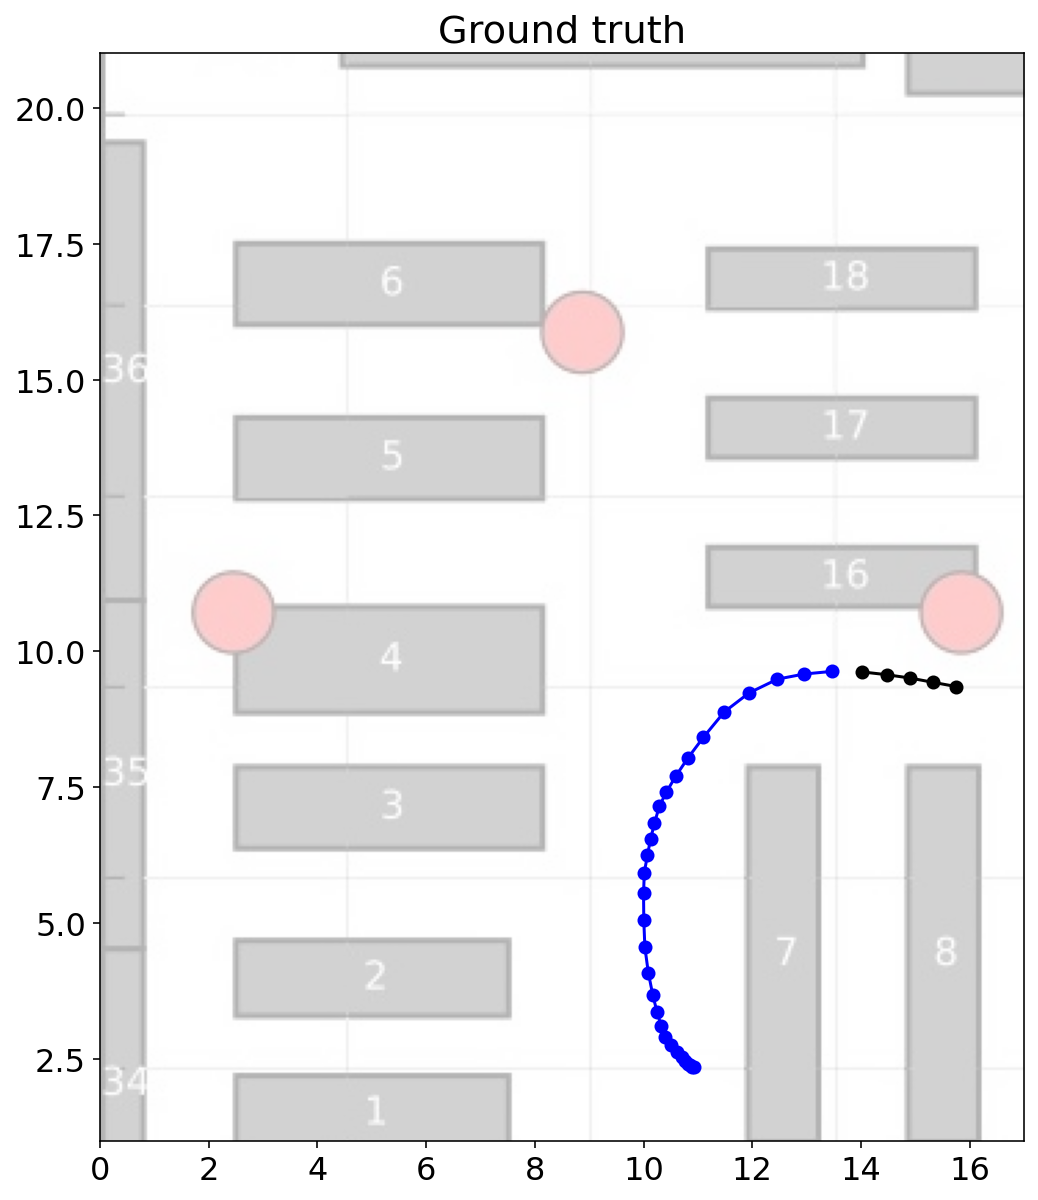

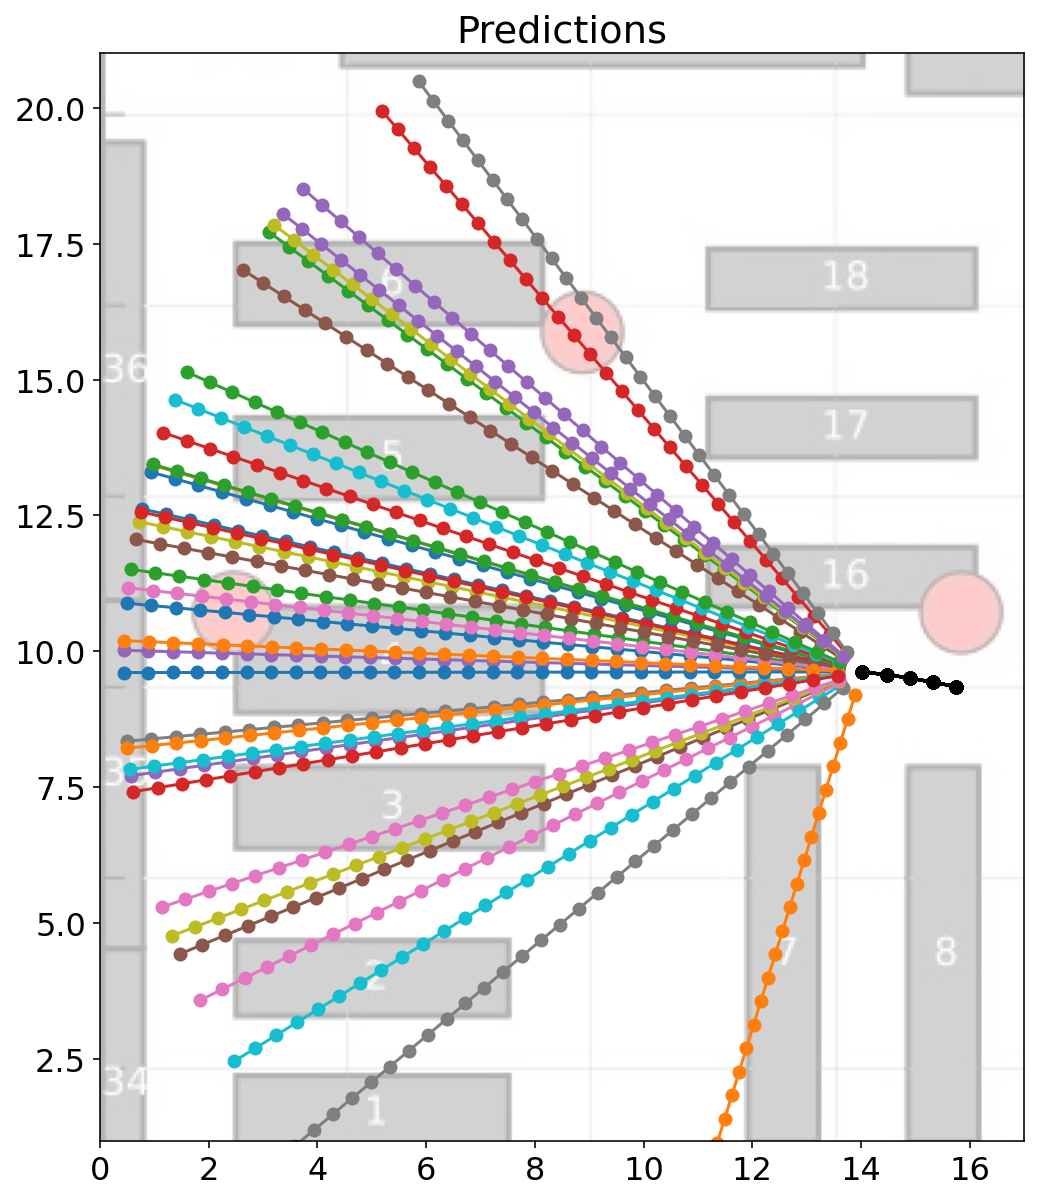

In [142]:
#idx = [0,1,2,3, 5, 10, 15,20,25,30]
# 8 9 24 29

#idx = [i for i in range(33)]
#idx = [0,1,2,7,8,9,11,12,14,19,20,29,30]
idx = [1,13,15,20,30]
idx = [19]

pad = 9
pad2 = 5
print_fig_traj(idx, pad)
#print_pure_traj(idx, pad2)

## Loss


In [35]:
data_curve = pd.read_csv(f"{PATH}\\log_curve.txt")
time = data_curve.index.values.tolist()
data_curve.columns

Index(['Epoch', 'Learning_rate', 'Train_ADE', 'Train_FDE', 'Valid_ADE',
       'Valid_FDE', 'traj_loss'],
      dtype='object')

In [36]:
data_curve

,Epoch,Learning_rate,Train_ADE,Train_FDE,Valid_ADE,Valid_FDE,traj_loss
0,1,0.0001,5.038636,7.861501,0.000000,0.000000,38.665769
1,2,0.0001,4.470027,7.132145,0.000000,0.000000,32.737512
2,3,0.0001,3.927403,6.424068,0.000000,0.000000,27.586015
3,4,0.0001,3.443473,5.798164,0.000000,0.000000,23.191339
4,5,0.0001,3.072670,5.293897,0.000000,0.000000,19.712118
...,...,...,...,...,...,...,...
225,226,0.0001,0.277420,0.478953,3.152056,5.557741,0.152026
226,227,0.0001,0.276721,0.475985,3.135859,5.527358,0.150913
227,228,0.0001,0.276707,0.475742,3.179212,5.621748,0.151139
228,229,0.0001,0.275839,0.473842,3.155949,5.566560,0.149665


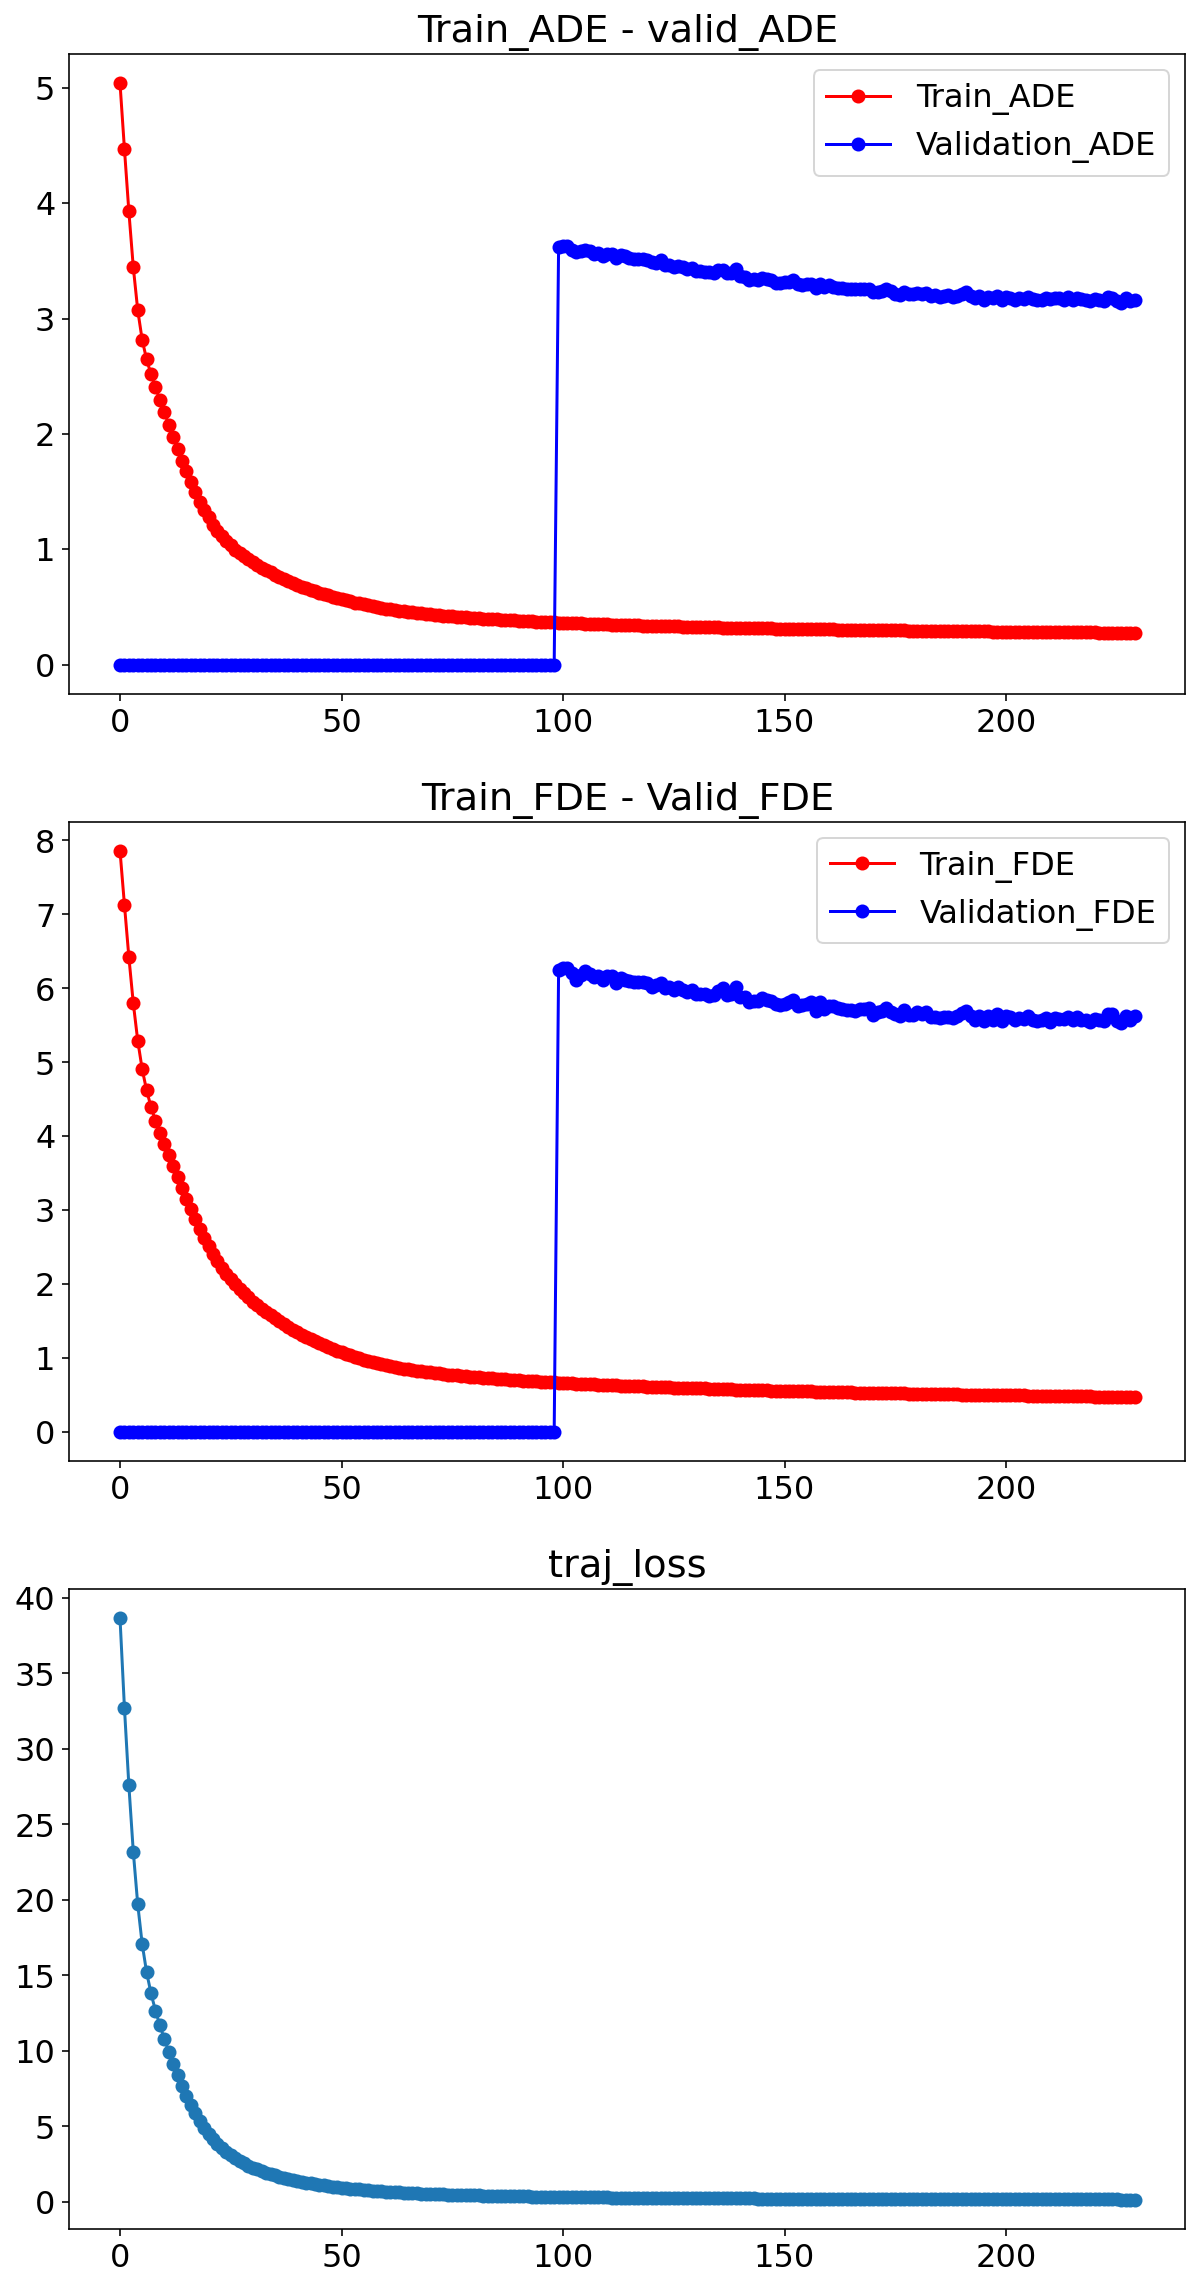

In [37]:
fig, ax = plt.subplots(3,figsize=(10, 20))

ax[0].plot(time, data_curve["Train_ADE"], f"-or", label='Train_ADE')
ax[0].plot(time, data_curve["Valid_ADE"], f"-ob",  label='Validation_ADE')
ax[0].set(title='Train_ADE - valid_ADE')
ax[0].legend()


ax[1].plot(time, data_curve["Train_FDE"], "-or", label='Train_FDE')
ax[1].plot(time, data_curve["Valid_FDE"], f"-ob",  label='Validation_FDE')
ax[1].set(title='Train_FDE - Valid_FDE')
ax[1].legend()

ax[2].plot(time, data_curve["traj_loss"], "-o")
ax[2].set(title='traj_loss')


plt.savefig(f"{PATH}\\statistics.png")

plt.show()

<p>Average Displacement Error (ADE):
<ul>
    <li>Average mean square error (MSE) over all time steps between the ground truth future trajectory x and the
        closest sample ˜x in the forecasted set of trajectories Yf. </li>
    <li>Refers to the mean square error (MSE) over all estimated points of every trajectory and the true points </li>
</ul>
    </p>

<p>Final Displacement Error (FDE): 
<ul>
    <li>MSE between the final ground truth position x_t and the closest sample’s final position ˜x_t </li>
    <li>FDE means the distance between the predicted final destination and the true final destination at the Tpred time.</li>
</ul>
</p>      